In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.manifold import TSNE

df = pd.read_csv('https://github.com/FourthRevGitHub/CAM_DS_Public-Data-Sets/raw/main/Course%201/Week%206/CUSTOMERS_CLEAN.zip')
df.head()

,Quantity,City,Continent,Postal_Code,State_Province,Order_Date,Delivery_Date,Total Revenue,Unit Cost,Discount,OrderTypeLabel,CustomerCountryLabel,Customer_BirthDate,Customer_Group,Customer_Type,Order ID,Profit,Days to Delivery,Loyalty Num,Customer ID
0,3,Leinster,Oceania,6437,Western Australia,01JAN2012,07JAN2012,$28.50,$9.10,.,Internet Sale,Australia,08MAY1978,Internet/Catalog Customers,Internet/Catalog Customers,1230000033,$1.20,6,99,8818
1,2,Berowra,Oceania,2081,New South Wales,01JAN2012,04JAN2012,$113.40,$56.90,.,Internet Sale,Australia,13DEC1978,Orion Club Gold members,Orion Club Gold members high activity,1230000204,($0.40),3,99,47793
2,2,Berowra,Oceania,2081,New South Wales,01JAN2012,04JAN2012,$41.00,$18.50,.,Internet Sale,Australia,13DEC1978,Orion Club Gold members,Orion Club Gold members high activity,1230000204,$4.00,3,99,47793
3,1,Northbridge,Oceania,2063,New South Wales,01JAN2012,03JAN2012,$35.20,$29.60,.,Internet Sale,Australia,22JUN1997,Orion Club Gold members,Orion Club Gold members high activity,1230000268,$5.60,2,0,71727
4,1,Montréal,North America,NaN,Quebec,01JAN2012,04JAN2012,$24.70,$23.60,.,Internet Sale,Canada,28JAN1978,Orion Club Gold members,Orion Club Gold members medium activity,1230000487,$1.10,3,99,74503


In [ ]:
print(df.isnull().sum())


Quantity                     0
City                       135
Continent                    0
Postal_Code               3716
State_Province          117192
Order_Date                   0
Delivery_Date                0
Total Revenue                0
Unit Cost                    0
Discount                     0
OrderTypeLabel               0
CustomerCountryLabel         0
Customer_BirthDate           0
Customer_Group               0
Customer_Type                0
Order ID                     0
Profit                       0
Days to Delivery             0
Loyalty Num                  0
Customer ID                  0
dtype: int64


In [ ]:
print("Duplicate rows:", df.duplicated().sum())

Duplicate rows: 21


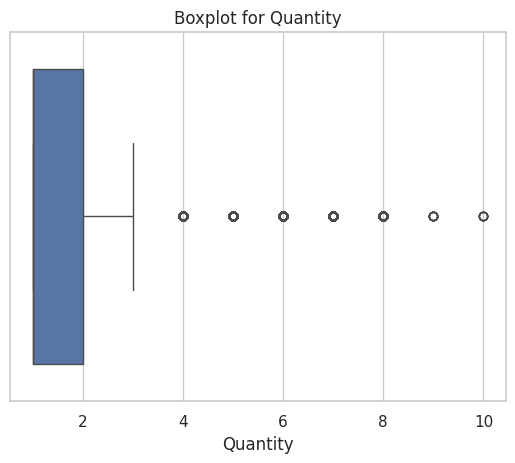

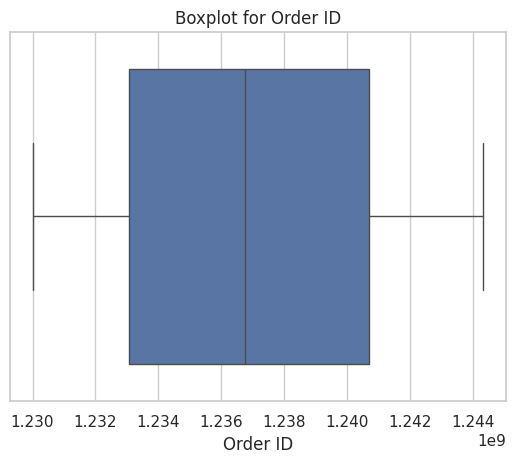

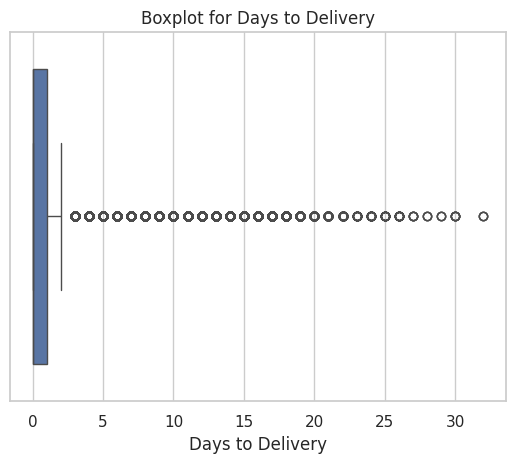

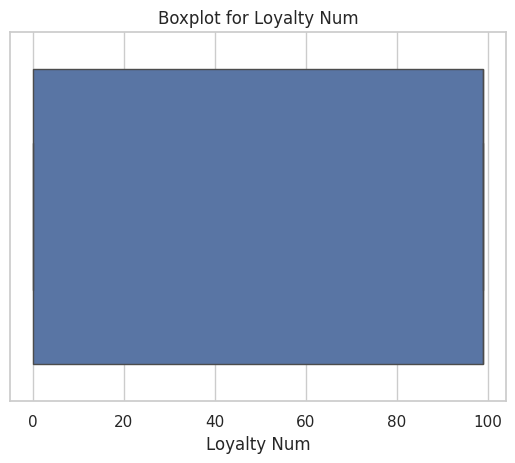

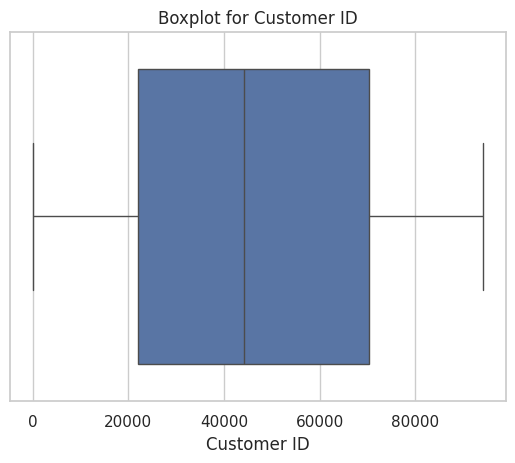

In [ ]:
numerical_cols = df.select_dtypes(include=np.number).columns

for col in numerical_cols:
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot for {col}')
    plt.show()

In [ ]:
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
print(df.columns)

Index(['quantity', 'city', 'continent', 'postal_code', 'state_province',
       'order_date', 'delivery_date', 'total_revenue', 'unit_cost', 'discount',
       'ordertypelabel', 'customercountrylabel', 'customer_birthdate',
       'customer_group', 'customer_type', 'order_id', 'profit',
       'days_to_delivery', 'loyalty_num', 'customer_id'],
      dtype='object')


In [ ]:
df['customer_id'].nunique(), df.shape[0]

(68300, 951669)

In [ ]:
# Convert dates
df['order_date'] = pd.to_datetime(df['order_date'])
df['customer_birthdate'] = pd.to_datetime(df['customer_birthdate'])

# Reference date for recency
reference_date = df['order_date'].max()

# Remove $ and commas from relevant columns and convert to float
df['unit_cost'] = df['unit_cost'].replace('[\$,]', '', regex=True).astype(float)
df['total_revenue'] = df['total_revenue'].replace('[\$,]', '', regex=True).astype(float)


# Aggregate to customer level
customer_df = df.groupby('customer_id').agg({
    'order_id': 'nunique',  # frequency
    'order_date': lambda x: (reference_date - x.max()).days,  # recency
    'total_revenue': 'sum',  # CLV
    'unit_cost': 'mean',  # avg cost
    'customer_birthdate': lambda x: (reference_date - x.max()).days // 365  # age
}).reset_index()

# Rename columns
customer_df.columns = ['customer_id', 'frequency', 'recency', 'clv', 'average_unit_cost', 'customer_age']

# Preview
customer_df.head()


,customer_id,frequency,recency,clv,average_unit_cost,customer_age
0,1,28,17,4322.70,89.622857,63
1,3,14,124,2821.00,90.505000,33
2,4,8,1108,782.67,37.195556,33
3,5,15,5,2810.98,107.947368,28
4,6,13,192,1604.58,52.526667,58


In [ ]:
features = ['frequency', 'recency', 'clv', 'average_unit_cost', 'customer_age']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(customer_df[features])

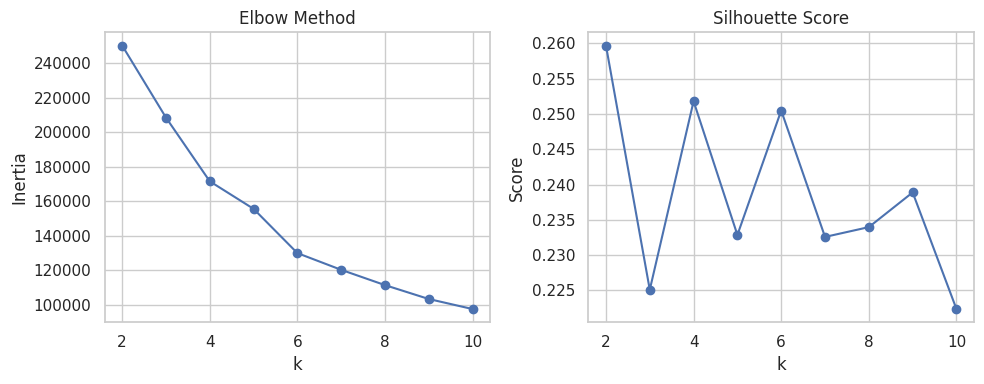

In [ ]:
# Elbow method
inertia = []
silhouette = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot results
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('k')
plt.ylabel('Inertia')

plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette, marker='o')
plt.title('Silhouette Score')
plt.xlabel('k')
plt.ylabel('Score')

plt.tight_layout()
plt.show()

In [ ]:
# Final k
k = 4

kmeans = KMeans(n_clusters=k, random_state=42)
customer_df['cluster'] = kmeans.fit_predict(X_scaled)

# View average feature values per cluster
cluster_summary = customer_df.groupby('cluster')[['frequency', 'recency', 'clv', 'average_unit_cost', 'customer_age']].mean().round(2)
cluster_summary


,frequency,recency,clv,average_unit_cost,customer_age
cluster,,,,,
0,8.47,234.19,1402.26,75.17,59.88
1,25.54,121.65,4852.11,83.03,38.94
2,9.48,238.18,1638.19,79.26,28.13
3,3.92,1118.19,693.10,80.81,47.36


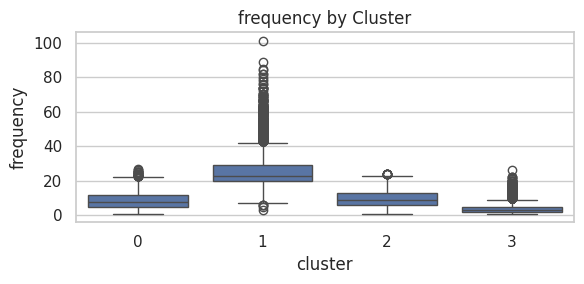

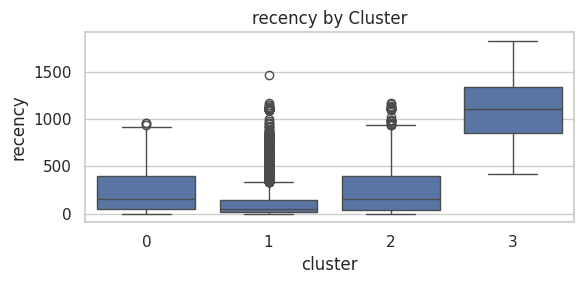

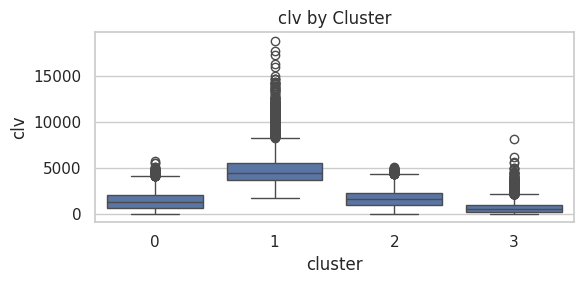

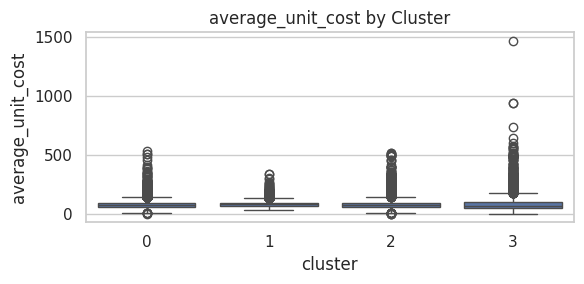

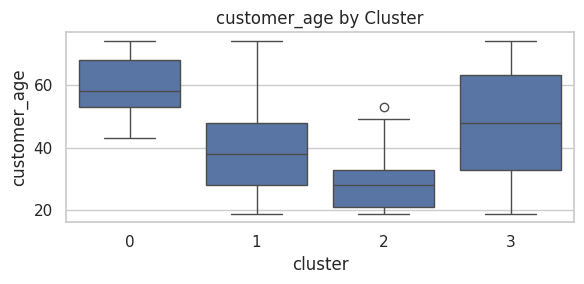

In [ ]:
features = ['frequency', 'recency', 'clv', 'average_unit_cost', 'customer_age']

for col in features:
    plt.figure(figsize=(6, 3))
    sns.boxplot(data=customer_df, x='cluster', y=col)
    plt.title(f'{col} by Cluster')
    plt.tight_layout()
    plt.show()

In [ ]:
# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_scaled)


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


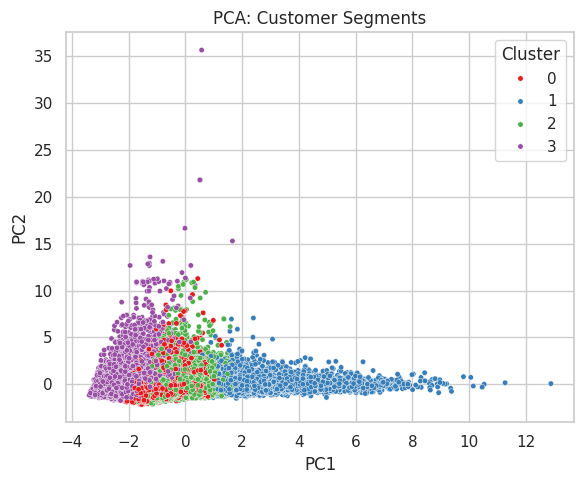

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


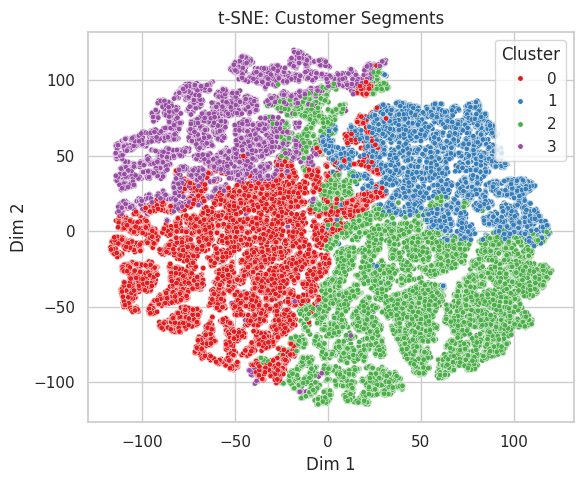

In [31]:
# PCA Plot
plt.figure(figsize=(6, 5))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=customer_df['cluster'], palette='Set1', s=15)
plt.title('PCA: Customer Segments')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

# t-SNE Plot
plt.figure(figsize=(6, 5))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=customer_df['cluster'], palette='Set1', s=15)
plt.title('t-SNE: Customer Segments')
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()


# Reflect

Write a brief paragraph highlighting your process and the rationale to showcase critical thinking and problem-solving.

> Select the pen from the toolbar to add your entry.

### Reference:
SAS, 2024. CUSTOMERS_CLEAN [Data set]. SAS. Last revised on 15 December 2021. [Accessed 20 February 2024].